<a href="https://colab.research.google.com/github/benedettoscala/ifttt-code-generator/blob/main/bart_nl2ifttt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install evaluate
!pip install rouge_score

In [2]:
!git clone https://github.com/benedettoscala/ifttt-code-generator
%cd ifttt-code-generator/
!git pull

fatal: destination path 'ifttt-code-generator' already exists and is not an empty directory.
/content/ifttt-code-generator
Already up to date.


Statistiche per la descrizione:
  Min: 6
  Max: 63
  Media: 25.476190476190474
  Mediana: 24.0

Statistiche per il codice:
  Min: 16
  Max: 177
  Media: 69.81547619047619
  Mediana: 61.5

Statistiche per il testo completo (descrizione + codice):
  Min: 28
  Max: 197
  Media: 96.29166666666667
  Mediana: 88.0



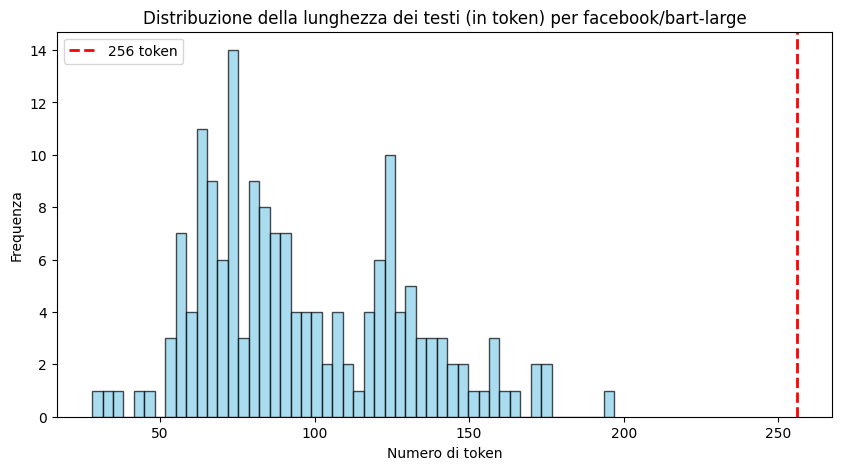

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Imposta il checkpoint del modello (BART-large)
model_checkpoint = "facebook/bart-large"

# Carica il tokenizer per facebook/bart-large
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Se il tokenizer non ha un token di padding definito, impostalo uguale al token EOS
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Carica il dataset
csv_path = "datasets/cleaned_and_combined.csv"
df = pd.read_csv(csv_path)

# Rimuovi righe con valori mancanti e duplicati nelle colonne di interesse
df.dropna(subset=["cleaned_description", "filter_code"], inplace=True)
df.drop_duplicates(subset=["cleaned_description", "filter_code"], inplace=True)

# Definisci un separatore per unire descrizione e codice
separator = "\n###\n"

# Liste per salvare le lunghezze in token
description_lengths = []
code_lengths = []
combined_lengths = []

# Itera su ogni esempio nel dataset
for _, row in df.iterrows():
    description = row["cleaned_description"]
    code = row["filter_code"]

    # Tokenizza la descrizione senza troncamento
    desc_tokens = tokenizer.encode(description, truncation=False)
    # Tokenizza il codice senza troncamento
    code_tokens = tokenizer.encode(code, truncation=False)
    # Tokenizza la concatenazione: descrizione + separatore + codice
    combined_text = description + separator + code
    combined_tokens = tokenizer.encode(combined_text, truncation=False)

    # Salva le lunghezze
    description_lengths.append(len(desc_tokens))
    code_lengths.append(len(code_tokens))
    combined_lengths.append(len(combined_tokens))

# Funzione per stampare statistiche (min, max, media, mediana)
def print_stats(name, lengths):
    print(f"Statistiche per {name}:")
    print("  Min:", np.min(lengths))
    print("  Max:", np.max(lengths))
    print("  Media:", np.mean(lengths))
    print("  Mediana:", np.median(lengths))
    print()

print_stats("la descrizione", description_lengths)
print_stats("il codice", code_lengths)
print_stats("il testo completo (descrizione + codice)", combined_lengths)

# Visualizza la distribuzione della lunghezza in token del testo completo
plt.figure(figsize=(10, 5))
plt.hist(combined_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(256, color='red', linestyle='dashed', linewidth=2, label="256 token")
plt.title("Distribuzione della lunghezza dei testi (in token) per facebook/bart-large")
plt.xlabel("Numero di token")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

### Import Libraries

In [4]:
from transformers import AutoTokenizer, BartForConditionalGeneration
from datasets import load_dataset,load_from_disk
import torch
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize

### Preprocessing Data

In [5]:
import os

In [6]:
%cd ..

/content


In [7]:
base_path = os.getcwd()
absolute_path = os.path.join(base_path,r'ifttt-code-generator/datasets/cleaned_and_combined.csv')

In [21]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset, DatasetDict

# Caricamento del dataset
csv_path = "ifttt-code-generatordatasets/cleaned_and_combined.csv"
df = pd.read_csv(absolute_path)

#droppa i duplicati e i valori nulli se ci sono
df.dropna(subset=["cleaned_description", "filter_code"], inplace=True)
df.drop_duplicates(subset=["cleaned_description", "filter_code"], inplace=True)

# Suddivisione in train e test set (80%-20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convertiamo i DataFrame in Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Stampa delle dimensioni dei set di training e test
print("Train set size:", len(dataset["train"]))
print("Test set size:", len(dataset["test"]))

Train set size: 134
Test set size: 34


### Model Checkpoint

In [22]:
model_checkpoint = "facebook/bart-large"

In [23]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [24]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

{'input_ids': [0, 100, 2638, 2600, 5, 27689, 3100, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [25]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['<s>', 'I', 'Ġloved', 'Ġreading', 'Ġthe', 'ĠHunger', 'ĠGames', '!', '</s>']

In [26]:
#show the first 2 rows of the dataset
dataset['train'][:2]

{'cleaned_description': ['Send yourself a calendar event to remind you to help your pet achieve their activity goals.',
  'If gcal has an event named "Work" set the Ecobee to away until transition.'],
 'filter_code': ['var hour = Meta.triggerTime.hour()  var minute = Meta.triggerTime.minute()  var timeHour = 24    if(hour%timeHour > 0 && minute%15 > 0)    GoogleCalendar.quickAddEvent.skip()',
  'if (GoogleCalendar.eventFromSearchStarts.Title.toUpperCase() != "WORK") {   Ecobee.climateNextTransition.skip() }'],
 '__index_level_0__': [80, 203]}

In [27]:
dataset['test']

Dataset({
    features: ['cleaned_description', 'filter_code', '__index_level_0__'],
    num_rows: 34
})

In [28]:
max_input_length = 256
max_target_length = 128
prefix1 = "ifttt_prompt: "
prefix2 = " ifttt_context: "


def preprocess_function(examples):
    model_inputs = tokenizer([prefix1 + prompt for prompt in examples['cleaned_description']],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples['filter_code'], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [29]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

### Metric

In [30]:
import evaluate

rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")
meteor_score = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Model

In [31]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [32]:
model.generation_config.max_new_tokens = 128
model.generation_config.min_new_tokens = 5
model.config.max_new_tokens = 128
model.config.min_new_tokens = 5

In [33]:
print(model.config)

BartConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "facebook/bart-large",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

In [34]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "max_new_tokens": 128,
  "min_new_tokens": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}



### Data Collator

In [35]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [36]:
tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [37]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[    0,  1594,  5967,    90,  1215, 12501,  3320,    35, 10683,  2512,
            10,  7127,   515,     7,  8736,    47,     7,   244,   110,  4716,
          3042,    49,  1940,  1175,     4,     2,     1,     1,     1],
        [    0,  1594,  5967,    90,  1215, 12501,  3320,    35,   318,   821,
         11762,    34,    41,   515,  1440,    22, 21461,   113,   278,     5,
         19722,  2413,  1942,     7,   409,   454,  3868,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), 'labels': tensor([[    0, 10806,  1946,  5457, 37622,     4, 45043, 14699,     4,  4509,
         43048,  1437, 15747,  2289,  5457, 37622,     4, 45043, 14699,     4,
          4530, 43048,  1437, 15747,    86, 40215,  5457,   706,  1437,  1437,
          1437,   114,  1640,  4509,   207,

### Data Loader

In [38]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=batch_size
)

### Optimizer

In [39]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

### HuggingFace Accelerator

In [40]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [41]:
len(train_dataloader)

17

### Optimizer Learning Rate Scheduler

In [42]:
from transformers import get_scheduler

num_train_epochs = 30
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

#### Post Processing for ROUGE computation

In [43]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [44]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Training Loop

In [45]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import numpy as np

# Variabili per tracciare la loss durante il training
training_losses = []
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    print(f"\nStarting Epoch {epoch + 1}/{num_train_epochs}")

    # Training
    model.train()
    epoch_loss = 0
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        # Traccia la loss per calcolare la media
        epoch_loss += loss.item()

    # Calcola e registra la loss media per l'epoca
    avg_loss = epoch_loss / len(train_dataloader)
    training_losses.append(avg_loss)
    print(f"Epoch {epoch + 1} Training Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    for step, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating Epoch {epoch + 1}")):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # Pad the labels too if needed
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)
            bleu_score.add_batch(predictions=decoded_preds, references=decoded_labels)
            meteor_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result_rouge = rouge_score.compute()
    result_bleu = bleu_score.compute()
    result_meteor = meteor_score.compute()
    # Extract the median ROUGE scores
    result_rouge = {key: value * 100 for key, value in result_rouge.items()}
    result_rouge = {k: round(v, 4) for k, v in result_rouge.items()}
    # Extract the median BLEU scores
    result_bleu = result_bleu["bleu"] * 100
    # Extract the meteor scores
    result_meteor = result_meteor["meteor"] * 100

    print(f"\nEpoch {epoch + 1} Results:")
    print(f"ROUGE: {result_rouge}")
    print(f"BLEU: {result_bleu:.2f}")
    print(f"METEOR: {result_meteor:.2f}")

    # Save and upload
    output_dir = 'nl2sql_epoch' + str(epoch + 1)
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)



  0%|          | 0/510 [00:00<?, ?it/s]


Starting Epoch 1/30
Epoch 1 Training Loss: 4.1712


Evaluating Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1 Results:
ROUGE: {'rouge1': 22.158, 'rouge2': 5.9344, 'rougeL': 19.0983, 'rougeLsum': 19.3543}
BLEU: 9.84
METEOR: 28.33


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



Starting Epoch 2/30
Epoch 2 Training Loss: 2.6806


Evaluating Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 2 Results:
ROUGE: {'rouge1': 34.0533, 'rouge2': 17.1756, 'rougeL': 31.1893, 'rougeLsum': 31.7566}
BLEU: 17.60
METEOR: 31.35

Starting Epoch 3/30
Epoch 3 Training Loss: 2.2811


Evaluating Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 3 Results:
ROUGE: {'rouge1': 35.1123, 'rouge2': 17.7402, 'rougeL': 32.1112, 'rougeLsum': 32.5383}
BLEU: 18.09
METEOR: 34.25

Starting Epoch 4/30
Epoch 4 Training Loss: 2.0062


Evaluating Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 4 Results:
ROUGE: {'rouge1': 34.8361, 'rouge2': 19.7249, 'rougeL': 33.2111, 'rougeLsum': 33.7024}
BLEU: 15.96
METEOR: 33.61

Starting Epoch 5/30
Epoch 5 Training Loss: 1.8107


Evaluating Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 5 Results:
ROUGE: {'rouge1': 34.967, 'rouge2': 19.1268, 'rougeL': 33.0934, 'rougeLsum': 33.5308}
BLEU: 17.90
METEOR: 35.03

Starting Epoch 6/30
Epoch 6 Training Loss: 1.7179


Evaluating Epoch 6:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 6 Results:
ROUGE: {'rouge1': 35.0926, 'rouge2': 20.0729, 'rougeL': 33.3967, 'rougeLsum': 33.6452}
BLEU: 19.96
METEOR: 34.11

Starting Epoch 7/30
Epoch 7 Training Loss: 1.7017


Evaluating Epoch 7:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 7 Results:
ROUGE: {'rouge1': 34.7171, 'rouge2': 21.8107, 'rougeL': 33.3089, 'rougeLsum': 33.8155}
BLEU: 16.52
METEOR: 31.59

Starting Epoch 8/30
Epoch 8 Training Loss: 1.4940


Evaluating Epoch 8:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 8 Results:
ROUGE: {'rouge1': 34.9203, 'rouge2': 21.1997, 'rougeL': 33.0484, 'rougeLsum': 33.6883}
BLEU: 20.59
METEOR: 37.92

Starting Epoch 9/30
Epoch 9 Training Loss: 1.3700


Evaluating Epoch 9:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 9 Results:
ROUGE: {'rouge1': 35.5112, 'rouge2': 21.6466, 'rougeL': 34.1578, 'rougeLsum': 34.5775}
BLEU: 20.13
METEOR: 37.11

Starting Epoch 10/30
Epoch 10 Training Loss: 1.2357


Evaluating Epoch 10:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 10 Results:
ROUGE: {'rouge1': 35.4008, 'rouge2': 20.7906, 'rougeL': 33.4942, 'rougeLsum': 33.6923}
BLEU: 20.77
METEOR: 36.63

Starting Epoch 11/30
Epoch 11 Training Loss: 1.1562


Evaluating Epoch 11:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 11 Results:
ROUGE: {'rouge1': 36.6382, 'rouge2': 21.5719, 'rougeL': 34.8928, 'rougeLsum': 35.1549}
BLEU: 22.70
METEOR: 39.21

Starting Epoch 12/30
Epoch 12 Training Loss: 1.1868


Evaluating Epoch 12:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 12 Results:
ROUGE: {'rouge1': 36.9269, 'rouge2': 22.3073, 'rougeL': 35.5866, 'rougeLsum': 35.7844}
BLEU: 21.94
METEOR: 37.69

Starting Epoch 13/30
Epoch 13 Training Loss: 1.1033


Evaluating Epoch 13:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 13 Results:
ROUGE: {'rouge1': 38.3656, 'rouge2': 24.0472, 'rougeL': 36.779, 'rougeLsum': 36.9549}
BLEU: 21.52
METEOR: 36.20

Starting Epoch 14/30
Epoch 14 Training Loss: 0.9896


Evaluating Epoch 14:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 14 Results:
ROUGE: {'rouge1': 38.0762, 'rouge2': 21.703, 'rougeL': 35.9462, 'rougeLsum': 36.0392}
BLEU: 23.08
METEOR: 37.18

Starting Epoch 15/30
Epoch 15 Training Loss: 0.9347


Evaluating Epoch 15:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 15 Results:
ROUGE: {'rouge1': 39.5531, 'rouge2': 24.1187, 'rougeL': 37.2967, 'rougeLsum': 37.4748}
BLEU: 22.76
METEOR: 37.20

Starting Epoch 16/30
Epoch 16 Training Loss: 0.8899


Evaluating Epoch 16:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 16 Results:
ROUGE: {'rouge1': 38.6541, 'rouge2': 22.74, 'rougeL': 36.4093, 'rougeLsum': 36.752}
BLEU: 20.87
METEOR: 36.31

Starting Epoch 17/30
Epoch 17 Training Loss: 0.8508


Evaluating Epoch 17:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 17 Results:
ROUGE: {'rouge1': 39.8803, 'rouge2': 24.1185, 'rougeL': 37.4333, 'rougeLsum': 37.8637}
BLEU: 21.91
METEOR: 36.50

Starting Epoch 18/30
Epoch 18 Training Loss: 0.8093


Evaluating Epoch 18:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 18 Results:
ROUGE: {'rouge1': 38.1297, 'rouge2': 23.458, 'rougeL': 36.5432, 'rougeLsum': 36.7821}
BLEU: 21.60
METEOR: 37.03

Starting Epoch 19/30
Epoch 19 Training Loss: 0.7981


Evaluating Epoch 19:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 19 Results:
ROUGE: {'rouge1': 38.7822, 'rouge2': 22.9865, 'rougeL': 36.6794, 'rougeLsum': 36.7825}
BLEU: 23.51
METEOR: 38.85

Starting Epoch 20/30
Epoch 20 Training Loss: 0.7764


Evaluating Epoch 20:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 20 Results:
ROUGE: {'rouge1': 39.7085, 'rouge2': 23.5991, 'rougeL': 37.4512, 'rougeLsum': 37.7433}
BLEU: 23.98
METEOR: 38.46

Starting Epoch 21/30
Epoch 21 Training Loss: 0.7685


Evaluating Epoch 21:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 21 Results:
ROUGE: {'rouge1': 39.7926, 'rouge2': 24.6069, 'rougeL': 37.7834, 'rougeLsum': 37.9835}
BLEU: 23.51
METEOR: 37.13

Starting Epoch 22/30
Epoch 22 Training Loss: 0.7172


Evaluating Epoch 22:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 22 Results:
ROUGE: {'rouge1': 40.8648, 'rouge2': 24.6308, 'rougeL': 38.695, 'rougeLsum': 38.8804}
BLEU: 26.23
METEOR: 39.09

Starting Epoch 23/30
Epoch 23 Training Loss: 0.7238


Evaluating Epoch 23:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 23 Results:
ROUGE: {'rouge1': 40.0272, 'rouge2': 24.7403, 'rougeL': 38.2216, 'rougeLsum': 38.5097}
BLEU: 26.59
METEOR: 39.20

Starting Epoch 24/30
Epoch 24 Training Loss: 0.6990


Evaluating Epoch 24:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 24 Results:
ROUGE: {'rouge1': 41.8391, 'rouge2': 25.1445, 'rougeL': 39.0012, 'rougeLsum': 39.2859}
BLEU: 25.25
METEOR: 39.08

Starting Epoch 25/30
Epoch 25 Training Loss: 0.6786


Evaluating Epoch 25:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 25 Results:
ROUGE: {'rouge1': 42.2255, 'rouge2': 25.6425, 'rougeL': 40.1464, 'rougeLsum': 40.3675}
BLEU: 27.11
METEOR: 39.91

Starting Epoch 26/30
Epoch 26 Training Loss: 0.6417


Evaluating Epoch 26:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 26 Results:
ROUGE: {'rouge1': 43.5947, 'rouge2': 26.2849, 'rougeL': 40.5034, 'rougeLsum': 40.4582}
BLEU: 27.81
METEOR: 40.97

Starting Epoch 27/30
Epoch 27 Training Loss: 0.6314


Evaluating Epoch 27:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 27 Results:
ROUGE: {'rouge1': 41.8523, 'rouge2': 25.7184, 'rougeL': 39.6609, 'rougeLsum': 39.8575}
BLEU: 26.70
METEOR: 38.62

Starting Epoch 28/30
Epoch 28 Training Loss: 0.6305


Evaluating Epoch 28:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 28 Results:
ROUGE: {'rouge1': 42.611, 'rouge2': 26.869, 'rougeL': 40.8356, 'rougeLsum': 40.6699}
BLEU: 25.85
METEOR: 39.73

Starting Epoch 29/30
Epoch 29 Training Loss: 0.6319


Evaluating Epoch 29:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 29 Results:
ROUGE: {'rouge1': 41.7027, 'rouge2': 26.732, 'rougeL': 40.0047, 'rougeLsum': 39.843}
BLEU: 26.54
METEOR: 39.55

Starting Epoch 30/30
Epoch 30 Training Loss: 0.6178


Evaluating Epoch 30:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 30 Results:
ROUGE: {'rouge1': 41.7628, 'rouge2': 26.3754, 'rougeL': 40.0936, 'rougeLsum': 40.0272}
BLEU: 27.89
METEOR: 40.65


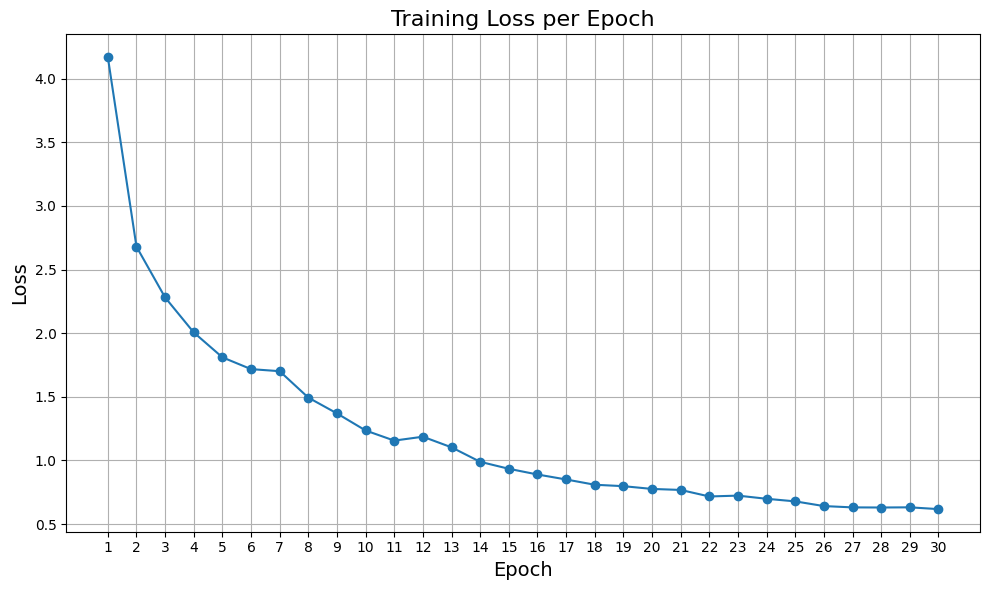

In [46]:
# Grafico della loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_train_epochs + 1), training_losses, marker='o')
plt.title("Training Loss per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.xticks(range(1, num_train_epochs + 1))
plt.tight_layout()
plt.show()

In [60]:

from transformers import pipeline


model_path = "nl2sql_epoch30"

# Load the pipeline
generator = pipeline("text2text-generation", model=model_path, tokenizer=model_path)

# Example usage
prompt = "ifttt prompt: Create an applet that Save new photos from my phone to a Google Drive folder automatically"
result = generator(prompt, max_length=128)

result

Device set to use cuda:0
Both `max_new_tokens` (=128) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'var title = Trigger.EntryTitle var savedPhotoURL = \'Google Drive\'  if (title.toUpperCase().indexOf("Photo") != -1) {    GoogleSheets.appendToGoogleSpreadsheet.skip("Not related to photos") }'}]


In [62]:

!zip -r nl2sql_epoch30.zip nl2sql_epoch30

  adding: nl2sql_epoch30/ (stored 0%)
  adding: nl2sql_epoch30/tokenizer.json (deflated 82%)
  adding: nl2sql_epoch30/tokenizer_config.json (deflated 76%)
  adding: nl2sql_epoch30/vocab.json (deflated 59%)
  adding: nl2sql_epoch30/merges.txt (deflated 53%)
  adding: nl2sql_epoch30/config.json (deflated 63%)
  adding: nl2sql_epoch30/special_tokens_map.json (deflated 52%)
  adding: nl2sql_epoch30/generation_config.json (deflated 49%)
  adding: nl2sql_epoch30/model.safetensors (deflated 7%)
